In [63]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage import filters
from skimage import exposure
import cv2
from math import pi, ceil, floor
import os
import time

plt.rcParams["figure.figsize"] = (10, 10)

#PATH = "./PHOTOS_MALARIA_VHIR_UPC/fotos_2015_12_01/P_falciparum/Trofozoits/DSCN0083.JPG"
PATH = "./samples/normal/blood_smear_2.JPG"
RESULT_PATH = "./samples/myresults/"
#PATH = "DSCN4223.JPG"

CELL_POINT_SIZE = 5
CELL_COLOR      = (255,60,0)
INTERNAL_COLOR  = (215,215,20)
EXTERNAL_COLOR  = (255, 255, 255)

CELL_HUE = 18
CELL_HUE_TOLERANCE = 4


# General functions

In [3]:
def saveResults(image_name, method_name, cells,internalInfection,externalInfection, passTime, img, path, method_ext):
    
    #save png
    out_path = "./samples/segmented/"
    if os.path.exists(out_path) == False:
        os.mkdir(out_path)
    name = path.split("/")[-1]
    out = out_path + name.lower().replace(".jpg",method_ext) + ".png"
    plt.imsave(out,img,format='png')
    
    
    
    #save txt
    image_name_parts = image_name.split("/")
    image_name = image_name_parts[-1]
    image_name = image_name.lower().replace(".jpg","")
    f_name = RESULT_PATH + image_name + "_result.txt"
    
    if os.path.exists(RESULT_PATH) == False:
        os.mkdir(RESULT_PATH)
    
    if os.path.exists(f_name):
        f = open(f_name,"r+")
        
        lines = f.read().split("\n")
        for l in range(len(lines)):
            line = lines[l]
            if line.startswith(method_name):
                lines[l] = f"{method_name:20}\t{cells:7}\t{internalInfection:8}\t{externalInfection:8}\t{passTime:6}\t{out}"
                txt = "\n".join(lines)
                
                f.truncate(0)
                f.seek(0)
                f.write(txt)
                f.close()
                return
    else:
        f = open(f_name,"w")
        f.write(f"{'METHOD':20}\t{'  CELLS':7}\t{'INTERNAL':8}\t{'EXTERNAL':8}\t{'TIME':6}\tFILE_NAME\n")
    f.write(f"{method_name:20}\t{cells:7}\t{internalInfection:8}\t{externalInfection:8}\t{passTime:6}\t{out}\n")
    f.close()
    
#saveResults("b","teste1",1,2,3,'5.5s')
    

In [4]:

def getImage(path=PATH, mode=0, size=(640,480), show=False):
    img = cv2.imread(path,mode)
    if mode == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img is None:
        print("Não foi possível abrir a imagem:", path)
    res = cv2.resize(img,size)
    if show:
        plt.figure(figsize=(10,10))
        plt.imshow(res)
        plt.show()
    return res

def applyBlur(img, k=9):
    return cv2.GaussianBlur(img,(k,k),0)

def otsu(img,block=81,offset=0.3):
    return cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,block,offset)

def adaptativeThresh(img,block=121,offset=0):
    return cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,block,offset)

def fillHoles(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    thresh_filled = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    color = 255
    for i in range(len(contours)):
        cv2.drawContours(thresh_filled, contours, i, color, -1, cv2.LINE_8, hierarchy, 0)
    return thresh_filled

def connectedComponents(thresh):
    output = cv2.connectedComponentsWithStats(thresh, 4, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    labeled_img_rgb = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB)
    return labeled_img_rgb, numLabels, labels, stats, centroids


def erode(src,size):
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * size + 1, 2 * size + 1),
                                       (size, size))
    return cv2.erode(src, element)
    
def dilate(src,size):
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * size + 1, 2 * size + 1),
                                       (size, size))
    return cv2.dilate(src, element)

def getPrincipalComponents(img):
    # Connected components with stats.
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=4)
    
    max_label, max_size = max([(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, nb_components)], key=lambda x: x[1])
    
    img2 = np.zeros(output.shape, dtype='uint8')
    img2[output == max_label] = 255
    return img2

def getPrincipalComponentRGB(img,mask):
    mask = getPrincipalComponents(mask)
    new = np.zeros(img.shape, dtype='uint8')
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if mask[x,y] == 255:
                new[x,y] = img[x,y]
    return new

def color_average(img):
    lista = img.reshape(img.shape[0]*img.shape[1],3)
    lista = lista[lista != [0,0,0]]
    lista = lista.reshape(len(lista)//3,3)
    avg = lista.mean(axis=0)
    avg = np.uint8(avg)
    median = np.median(lista, axis=0)
    return avg, median

def hsv_average(img):
    hues = []
    lista = img.reshape(img.shape[0]*img.shape[1],3)
    for i in range(0,len(lista),3):
        if lista[i][0] != 0:
            hues.append(lista[i][0])
    avg = int(np.mean(hues))
    median = int(np.median(hues))
    return avg, median

def color_distance(rgb1, rgb2):
        rm = 0.5 * (rgb1[0] + rgb2[0])
        rd = ((2 + rm) * (rgb1[0] - rgb2[0])) ** 2
        gd = (4 * (rgb1[1] - rgb2[1])) ** 2
        bd = ((3 - rm) * (rgb1[2] - rgb2[2])) ** 2
        return (rd + gd + bd) ** 0.5

In [5]:
MIN_CELL_AREA = 500
MAX_CELL_AREA = 2700#2300





def cutCircle(img,pos,radius):
    mask = np.zeros((img.shape[0],img.shape[1]))
    cv2.circle(mask, pos, radius, 1, -1)
    new = np.zeros(img.shape, dtype='uint8')
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if mask[x,y] > 0:
                new[x,y] = img[x,y]
    return new



def markCells(img, mask, components = None):
    
    font = img.copy()
    if components == None:
        labeled_img_rgb, numLabels, labels, stats, centroids = connectedComponents(mask)
        #o primeiro componente é o fundo, deve ser ignorado sempre
        start = 1
    else:
        labeled_img_rgb, numLabels, labels, stats, centroids = components
        
        start = 0
    
    cellsCount = 0

    for i in range(start, numLabels):
        # extract the connected component statistics and centroid for
        # the current label
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        #get area
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]

        #print(minArea, area, maxArea) minArea=MIN_CELL_AREA, maxArea=MAX_CELL_AREA
        if MIN_CELL_AREA < area < MAX_CELL_AREA:
            cellsCount += 1
            
            pos = (int(cX), int(cY))
            #radius = (w+h)//2
            #cut = cutCircle(img, pos, radius)
            rgb_cut = font[y:y+h,x:x+w]
            
            if mask is None:
                cut = labels[i]
            else:
                cut = mask[y:y+h,x:x+w]
                
            #plt.imshow(cut)
            #plt.show()
            
            rgb_cut = getPrincipalComponentRGB(rgb_cut,cut)
            #verifica se a mediana da cor da celula esta dentro dos valores adequados
            hsv_cut = cv2.cvtColor(rgb_cut,cv2.COLOR_RGB2HSV)
            avg, median = hsv_average(hsv_cut)
            
            if median < CELL_HUE - CELL_HUE_TOLERANCE or median > CELL_HUE + CELL_HUE_TOLERANCE:
                continue
            
            #cDist1 = color_distance(avg, (100,85,62))
            #cDist2 = color_distance(median, (100,85,62))
#             if cDist2 > 1700:
#                 print(avg, cDist1, median, cDist2)
#                 plt.title(cellsCount)
#                 plt.imshow(rgb_cut)
#                 plt.show()
#                 continue
            
            cv2.circle(img, pos, CELL_POINT_SIZE, (0,0,0), -1)
            cv2.circle(img, pos, CELL_POINT_SIZE-1, CELL_COLOR, -1)
            
            
            
            cv2.putText(img, str(cellsCount), (int(cX)+2, int(cY)+2), cv2.FONT_HERSHEY_SIMPLEX,
                        .4, (0,0,0),       2, cv2.LINE_AA)
            cv2.putText(img, str(cellsCount), (int(cX)+3, int(cY)+3), cv2.FONT_HERSHEY_SIMPLEX,
                        .4, (255,255,255), 1, cv2.LINE_AA)
            
            
            
        
        
        if MAX_CELL_AREA < area:
            
            rgb_cut = font[y:y+h,x:x+w]
            
            if mask is None:
                cut = labels[i]
            else:
                cut = mask[y:y+h,x:x+w]
            
            
            rgb_cut = getPrincipalComponentRGB(rgb_cut,cut)
            hsv_cut = cv2.cvtColor(rgb_cut,cv2.COLOR_RGB2HSV)
            avg, median = hsv_average(hsv_cut)
            
            if median < CELL_HUE - CELL_HUE_TOLERANCE or median > CELL_HUE + CELL_HUE_TOLERANCE:
                continue
            
#             avg, median = color_average(rgb_cut)
#             cDist1 = color_distance(avg, (100,85,62))
#             cDist2 = color_distance(median, (100,85,62))
#             #print(avg, cDist1, median, cDist2)
            
#             if cDist2 > 1700:
#                 continue
            
#             plt.title(cellsCount+1)
#             plt.imshow(rgb_cut)
#             plt.show()
            
            
            est = ceil(area/MAX_CELL_AREA)
            cv2.circle(img, (int(cX)-7, int(cY)), CELL_POINT_SIZE, (0,0,0), -1)
            cv2.circle(img, (int(cX)-7, int(cY)), CELL_POINT_SIZE-1, CELL_COLOR, -1)
            
            txt = "("+(",".join([str(q) for q in range(cellsCount+1,cellsCount+est+1,1)]))+")"
            
            cv2.putText(img, txt, (int(cX)+2, int(cY)+2), cv2.FONT_HERSHEY_SIMPLEX,
                        .4, (0,0,0),       2, cv2.LINE_AA)
            cv2.putText(img, txt, (int(cX)+3, int(cY)+3), cv2.FONT_HERSHEY_SIMPLEX,
                        .4, (255,255,255), 1, cv2.LINE_AA)
            cellsCount += est
            
            cv2.rectangle(img, (x,y), (x+w,y+h), CELL_COLOR, 1)
 
    return img, cellsCount

def breakBigGroups(mask,_erode=15,_dilate=11):
    
    labeled_img_rgb, numLabels, labels, stats, centroids = connectedComponents(mask)


    for i in range(1, numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]

        cutY = y - 1 if y > 0 else y
        cutX = x - 1 if x > 0 else x
        cutXW = x+w+1
        cutYH = y+h+1            
            
        cut = mask[cutY:cutYH, cutX:cutXW]
        cut = cut.copy()

        if MAX_CELL_AREA < area:
            cut_bk = cut.copy()
            cut = getPrincipalComponents(cut)

            #remove the group from original image
            cell_on_original_size = np.zeros( mask.shape ,dtype='uint8')
            cell_on_original_size[cutY:cutYH, cutX:cutXW] = cut
            mask[ cell_on_original_size == 255 ] = 0

            #work on group
            #cut = cv2.erode(cut, kernel, iterations=1)
            cut = erode(cut,_erode)
            cut = dilate(cut,_dilate)

            #return the eroded and marked group to original image
            cell_on_original_size = np.zeros( mask.shape ,dtype='uint8')
            cell_on_original_size[cutY:cutYH, cutX:cutXW] = cut
            mask += cell_on_original_size
    
    return mask


# Colors functions

In [53]:
def random_color():
    color = tuple(np.random.randint(1,256, size=3))
    if (color[0] < 100 and color[1] < 100 and color[2] < 100):
        return random_color()
    elif (color[0] > 230 and color[1] > 230 and color[2] > 230):
        return random_color()
    else:
        return (int(color[0]),int(color[1]),int(color[2]))
    

def list_colors(img):
    shape = img.shape
    if (len(shape) == 2):
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    
    reshapedImg = img.reshape(1,shape[0]*shape[1],3)[0]
    colors = np.unique(reshapedImg, axis=0)
    colors = np.delete(colors,0,axis=0)
    return colors


def shuffle_colors(img):
    
    if len(img.shape) == 2:
        img = cv2.merge([img,img,img])

    colors = list_colors(img)
    labeled_img_rgb3 = img.copy()

    for color in colors:
        newColor = random_color()

        red, green, blue = labeled_img_rgb3.T 
        selected_color = (red == color[0]) & (green == color[1]) & (blue == color[2])
        labeled_img_rgb3[selected_color.T] = newColor
    return labeled_img_rgb3


def colorize(img):
    labeled_rgb, numLabels, labels, stats, centroids = connectedComponents(img)
    return shuffle_colors(labeled_rgb)

         

# Parasites functions

In [7]:

def hsvParMask(img):
    #range 1
    fromColor=(120,70,20)
    toColor=(180,190,110)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask1 = cv2.inRange(hsv, fromColor, toColor)
    
    #range 2
    fromColor=(0,70,85)
    toColor=(15,75,105)
    
    mask2 = cv2.inRange(hsv, fromColor, toColor)
    
    
    mask = np.zeros(img.shape)
    mask = cv2.bitwise_or(mask1,mask2)
    
    #mask = maskConditionalBlur(mask,3,3)
    #mask = maskConditionalBlur(mask,30,40)
    #mask = cv2.inRange(hsv, fromColor, toColor)
    mask_dilated = mask.copy()
    #erode
    kernel = np.ones((3, 3), np.uint8)
    mask_dilated = cv2.erode(mask_dilated, kernel)
    #dilate
    kernel = np.ones((15, 15), np.uint8)
    mask_dilated = cv2.dilate(mask_dilated, kernel)

    return mask, mask_dilated


def gsParasiteMask(gsImg):
    if (len(gsImg.shape) == 3):
        gsImg = cv2.cvtColor(gsImg,cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gsImg, 75, 1, cv2.THRESH_BINARY_INV)
    return thresh

def remove_parasites(img,mask):
    maximum = np.max(mask)
    img[mask == maximum] = 0
    img = erode(img,2)
    img = dilate(img,2)
    return img

MIN_PARASITE_AREA = 20


def markParasites(img, parasite_mask, cell_mask, cell_components = None, contact_percent=0.15):
    
    
    labeled_rgb, numLabels, labels, stats, centroids = connectedComponents(parasite_mask)
    
    if cell_components is None:
        _, _, _, cell_stats, _ = connectedComponents(cell_mask)
    else:
        cell_mask = cv2.cvtColor(cell_components[0],cv2.COLOR_RGB2GRAY)
        cell_stats = cell_components[3]
    
    internal_count = 0
    external_count = 0
    
    
    for i in range(1, numLabels):
        area = stats[i, cv2.CC_STAT_AREA]
        #se for apenas pequenos pontos nao conta
        if MIN_PARASITE_AREA > area:
            continue
        
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        (cX, cY) = centroids[i]
        
        color = EXTERNAL_COLOR
        c = 0
        for cell_stat in cell_stats:
            c += 1
            cellArea  = cell_stat[cv2.CC_STAT_AREA]
            cellX = cell_stat[cv2.CC_STAT_LEFT]
            cellY = cell_stat[cv2.CC_STAT_TOP]
            cellW = cell_stat[cv2.CC_STAT_WIDTH]
            cellH = cell_stat[cv2.CC_STAT_HEIGHT]
            
            if MIN_CELL_AREA < cellArea < MAX_CELL_AREA*10:
                #faz um recorte da celula e do parasita
                cell_cut                                       = np.zeros(parasite_mask.shape)
                cell_cut[cellY:cellY+cellW, cellX:cellX+cellH] = cell_mask[cellY:cellY+cellW, cellX:cellX+cellH]
                par_cut                = np.zeros(parasite_mask.shape)
                par_cut[y:y+h, x:x+w]  = parasite_mask[y:y+h, x:x+w]
                
                
                #verifica a superficie em contato
                contact = np.zeros(cell_cut.shape)
                contact[cv2.bitwise_and(cell_cut,par_cut) > 0] = 1
                contact_percent_calc = np.sum(contact) / area

                #se atingir o minimo esperado, classifica interno
                if contact_percent_calc >= contact_percent:
                    color = INTERNAL_COLOR
                    cv2.rectangle(img, (cellX,cellY), (cellX+cellW,cellY+cellH), (0,255,0), 1)
                    break
        
        if color == INTERNAL_COLOR:
            internal_count += 1
        else:
            external_count += 1
        #caso nao esteja em contato com nenhuma celula, é externo
        cv2.rectangle(img, (x,y), (x+w,y+h), color, 1)
        
    return img, internal_count, external_count


# img = getImage(mode=1)
# par_mask = gsParasiteMask(imgGS)
# img, internal, external = markParasites(img, par_mask, cell_mask)
# plt.imshow(img)
# plt.show()

# Thresholding
## OTSU

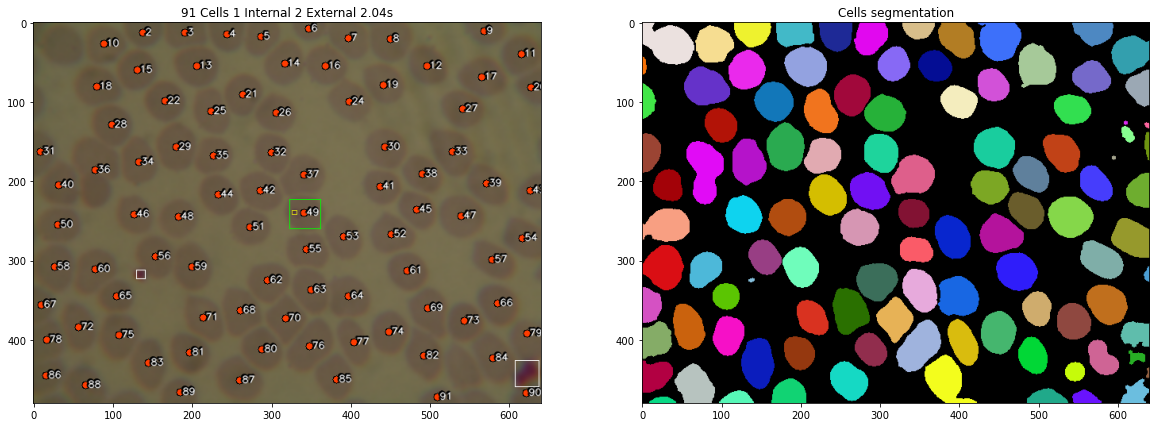

In [8]:
def otsu_method(path, blur=True):
    """
    Returns: (img, cell_mask_colored), (cells, internal, external, passTime)
    """
    start = time.time()
    #read in grayscale
    imgGS = getImage(path=path)
    #read in colors
    img = getImage(path=path,mode=1)

    #apply blur
    name = "OTSU w/out blur"
    method_ext = "_otsu_out_blur"
    if blur:
        name = "OTSU"
        method_ext = "_otsu"
        imgGS = applyBlur(imgGS)
        img = applyBlur(img)

    #otsu adaptative
    cell_mask = otsu(imgGS)

    #hsv mask
    #par_mask, par_mask_dilated = hsvParMask(img)
    #GS mask
    par_mask = gsParasiteMask(imgGS)

    #remove parasites from otsu
    cell_mask = remove_parasites(cell_mask,par_mask)

    #fill holes
    cell_mask = fillHoles(cell_mask)

    #break gorup of cells
    cell_mask = breakBigGroups(cell_mask)

    #colorize the cells
    cell_mask_colored = colorize(cell_mask)

    #mark
    img, cells = markCells(img, cell_mask)
    img, internal, external = markParasites(img, par_mask, cell_mask)

    end = time.time()


    passTime = "%.2fs" % (end-start)

    #save results
    saveResults(path,name,cells,internal,external, passTime, img, path, method_ext)
    
    return (img, cell_mask_colored), (cells, internal, external, passTime)


if __name__ == '__main__':

    images, stats = otsu_method(PATH)
    img, cell_mask = images
    cells, internal, external, passTime = stats 


    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()

## OTSU without blur

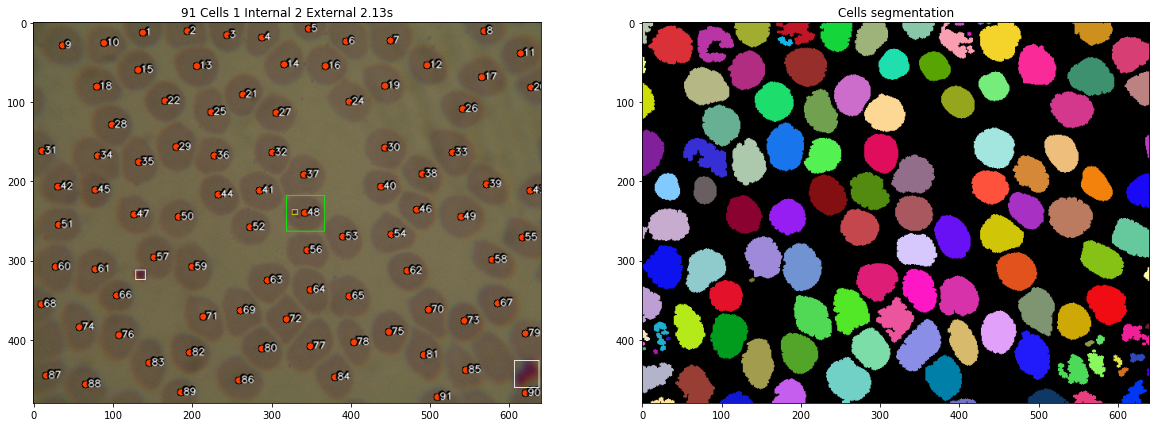

In [9]:
if __name__ == '__main__':

    images, stats = otsu_method(PATH, blur=False)
    img, cell_mask = images
    cells, internal, external, passTime = stats 

    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()


# HSV

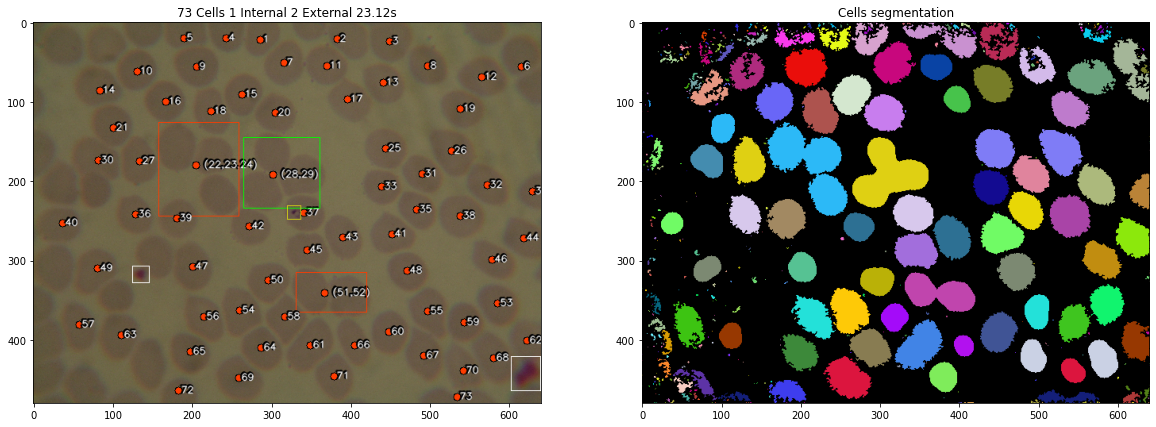

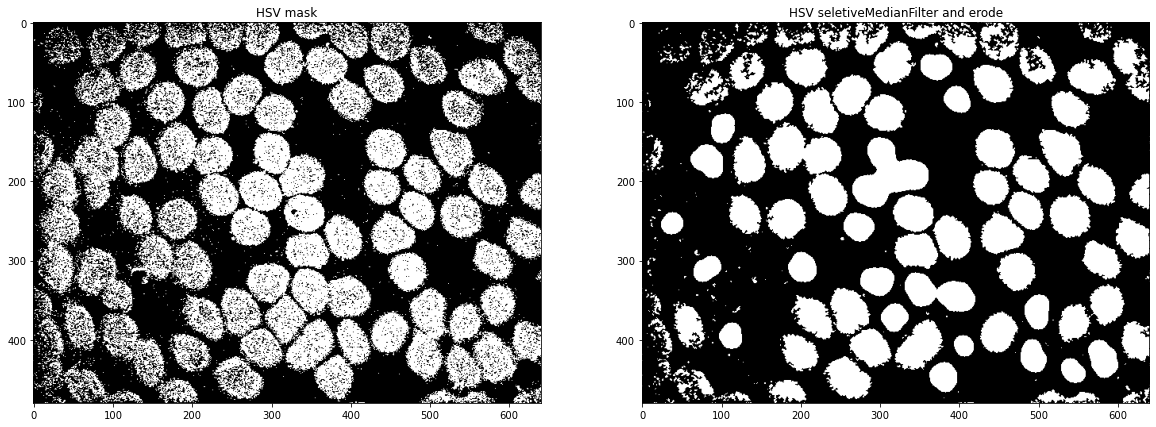

In [58]:
def cellHSVMask(img, fromColor=(0,70,0),toColor=(19,100,130)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, fromColor, toColor)
    return mask

def seletiveMedianFilter(img, kernel_size):
        
    new_img = img.copy()
    divided = floor(kernel_size/2)
    
    for i in range(divided,img.shape[0]-divided,1):
        for j in range(divided,img.shape[1]-divided,1):
            space = img[i-divided:i+divided+1,j-divided:j+divided+1]
            if np.median(space) == 0:
                new_img[i,j] = np.median(space)
            
    return new_img


def mergeCellsParts(mask):
    
    mask = mask.copy()
    labeled_img_rgb, numLabels, labels, stats, centroids = connectedComponents(mask)


    for i in range(1, numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]

        cutY = y - 1 if y > 0 else y
        cutX = x - 1 if x > 0 else x
        cutXW = x+w+1
        cutYH = y+h+1            
            
        cut = mask[cutY:cutYH, cutX:cutXW]
        
        
        if 50 < area < MAX_CELL_AREA:
            thresh_filled = cut
                
            contours, hierarchy = cv2.findContours(thresh_filled, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)
            hull = []
            for y in range(len(contours)):
                hull.append(cv2.convexHull(contours[y], False))    
            cv2.drawContours(thresh_filled, hull, -1, 255, 1, 8)
            
            contours, hierarchy = cv2.findContours(thresh_filled, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for i in range(len(contours)):
                cv2.drawContours(thresh_filled, contours, i, 255, -1, cv2.LINE_8, hierarchy, 0)
            
        elif MAX_CELL_AREA < area:
            
            #preenche
            contours, hierarchy = cv2.findContours(cut, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for i in range(len(contours)):
                cv2.drawContours(cut, contours, i, 255, -1, cv2.LINE_8, hierarchy, 0)
            
            #erode as bordas
            contours, hierarchy = cv2.findContours(cut, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)
            for i in range(len(contours)):
                cv2.drawContours(cut, contours, i, 100, 1, cv2.LINE_8, hierarchy, 0)
            
            
            #nao deixa apagar nas bordas do corte
            for x in range(cut.shape[0]):
                if (cut[x,0] == 100):
                    cut[x,0] = 255
                if (cut[x,cut.shape[1]-1] == 1):
                    cut[x,cut.shape[1]-1] = 255
            for y in range(cut.shape[1]):
                if (cut[0,y] == 100):
                    cut[0,y] = 255
                if (cut[cut.shape[0]-1,y] == 1):
                    cut[cut.shape[0]-1,y] = 255
                    
            cut[cut == 100] = 0
            
            #cut[True] = mergeCellsParts(cut)
            
            #plt.figure(figsize=(10,10))
            #plt.imshow(cut)
            #plt.show()
        
    return mask
            


def hsv_method(path, erode=True):

    start = time.time()

    #read in grayscale
    imgGS = getImage(path=path)
    #read in colors
    img = getImage(path=path,mode=1)

    #otsu adaptative
    cell_mask = cellHSVMask(img)
    
    #hsv parasite mask
    par_mask, par_mask_dilated = hsvParMask(img)
    cell_mask_bk = cell_mask.copy()

    if erode:
        name = "HSV"
        method_ext = "_hsv"
        cell_mask = seletiveMedianFilter(cell_mask,3)
        #fill holes
        cell_mask = fillHoles(cell_mask)
        #break gorup of cells
        cell_mask = breakBigGroups(cell_mask)
    else:
        name = "HSV w/out erode"
        method_ext = "_hsv_out_erode"
        cell_mask = mergeCellsParts(cell_mask)
        cell_mask = breakBigGroups(cell_mask,_erode=5,_dilate=3)

    #colorize the cells
    cell_mask_colored = colorize(cell_mask)

    #mark
    img, cells = markCells(img, cell_mask)
    img, internal, external = markParasites(img, par_mask_dilated, cell_mask)

    end = time.time()

    passTime = "%.2fs" % (end-start)
    #save results
    saveResults(path,name,cells,internal,external,passTime, img, path, method_ext)

    return (img, cell_mask_colored, cell_mask_bk, cell_mask), (cells,internal,external,passTime)
    
    
if __name__ == '__main__':

    images, stats = hsv_method(PATH)
    img, cell_mask_colored, cell_mask_bk, cell_mask = images
    cells,internal,external,passTime = stats

    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))    

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask_colored, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()

    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))

    ax[0].imshow(cell_mask_bk, cmap='gray')
    ax[0].set_title("HSV mask")
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("HSV seletiveMedianFilter and erode")
    plt.show()


# HSV Without erode

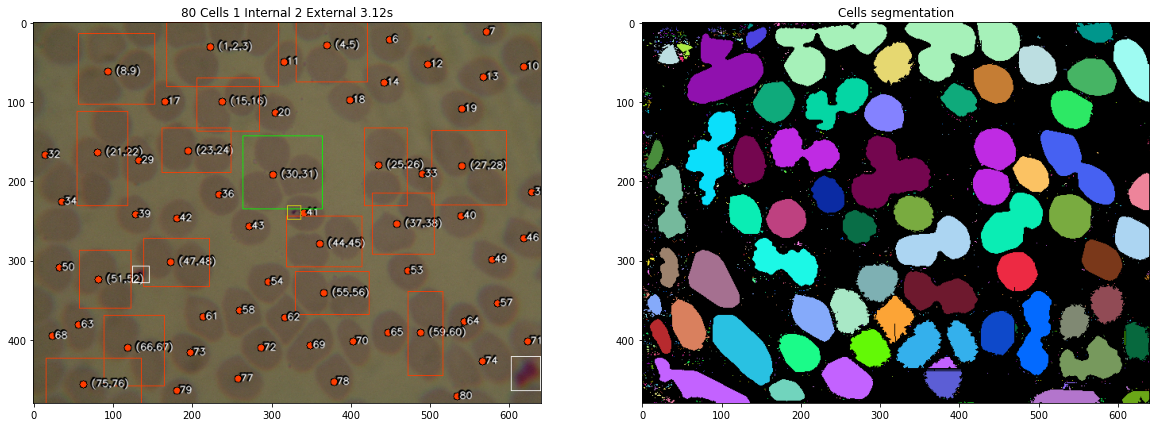

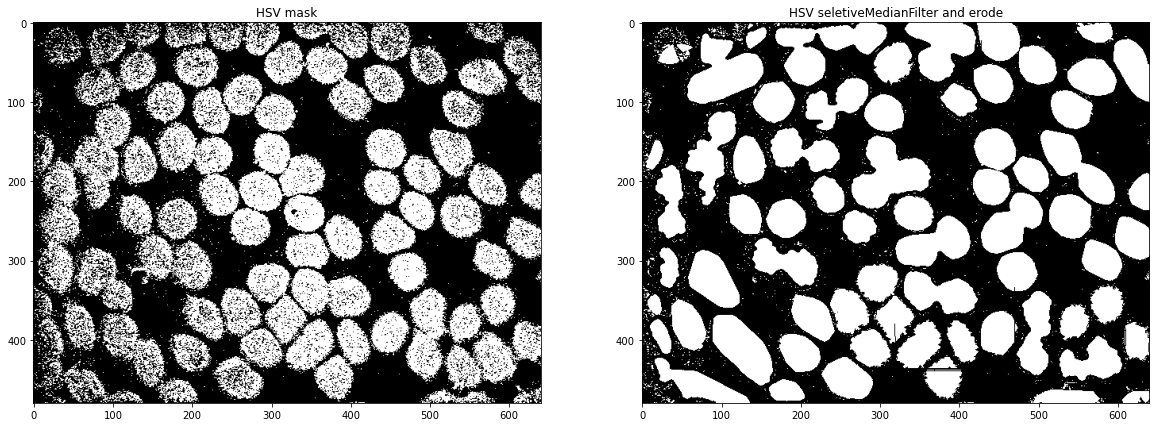

In [11]:
if __name__ == '__main__':
    images, stats = hsv_method(PATH, erode=False)

    img, cell_mask_colored, cell_mask_bk, cell_mask = images
    cells,internal,external,passTime = stats

    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))    

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask_colored, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()

    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))

    ax[0].imshow(cell_mask_bk, cmap='gray')
    ax[0].set_title("HSV mask")
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("HSV seletiveMedianFilter and erode")
    plt.show()

# Watershed

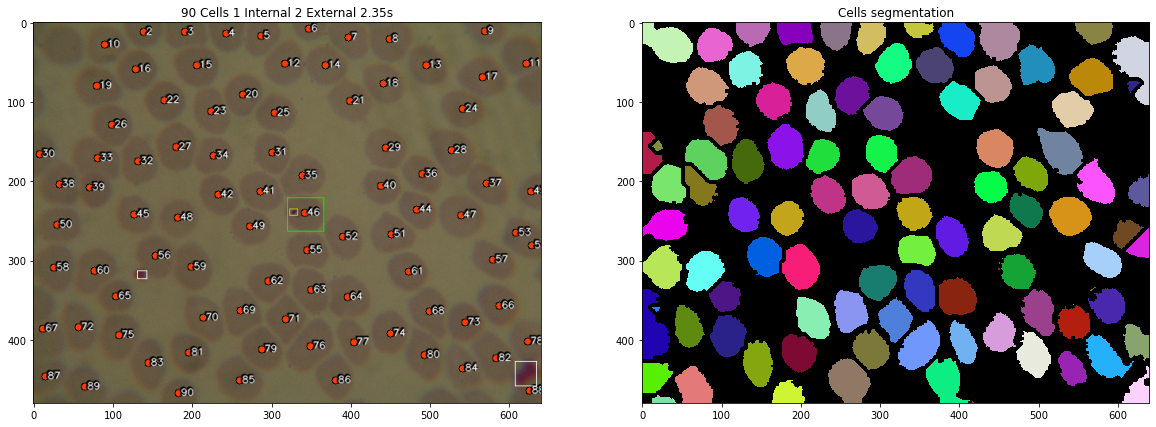

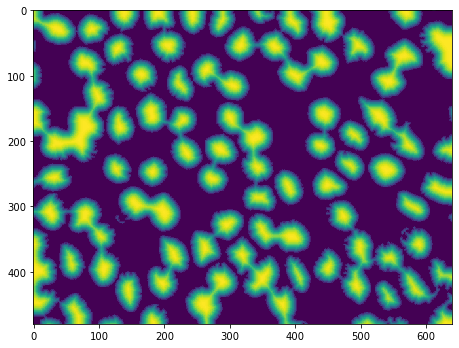

In [12]:
#https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html#sphx-glr-auto-examples-segmentation-plot-watershed-py
#https://docs.opencv.org/4.5.3/dd/d49/tutorial_py_contour_features.html

from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import imutils
from skimage import measure
from skimage.segmentation import random_walker

MAX_CELL_AREA = 2700


def applyWatershed(cell_mask):
    D = ndimage.distance_transform_edt(cell_mask)
    
    localMax = peak_local_max(D, min_distance=10, 
                                  #threshold_rel=0,
                                  #exclude_border=True,
                                  threshold_abs=10, 
                                  labels=cell_mask)
    
    peak_mask = np.zeros_like(cell_mask, dtype=bool)
    peak_mask[tuple(localMax.T)] = True
    
    
    
    numLabels, labels, stats, centroids = [], [], [], []
    

    markers = ndimage.label(peak_mask, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=cell_mask,watershed_line=True)
    
    watershed_lines = np.zeros(shape=np.shape(labels),dtype='uint8')
    watershed_lines[labels==0] = 1 # ws lines are labeled as 0 in markers
    watershed_lines = dilate(watershed_lines,2)
    
    new = np.ones(labels.shape,dtype='uint8')
    new -= watershed_lines
    
    labeled, numLabels, labels, stats, centroids = connectedComponents(new)
    labeled = shuffle_colors(labeled)
    labeled = np.uint8(labeled);
    
    
    newLabels = []
    i = 0
    for label in np.unique(labels):
        
        m = (labels == label)  # boolean array/mask of pixels with this label
        newLabel = np.zeros((labeled.shape[0],labeled.shape[1]),dtype='uint8')
        newLabel[m] = 255
        
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        
        newLabel = newLabel[y:y+h, x:x+w]
        newLabels.append(newLabel)
        i += 1
        
    #remove o background dos components
    numLabels -= 1
    newLabels  = newLabels[1:]
    stats      = stats[1:]
    centroids  = centroids[1:]
    
    return (labeled, numLabels, newLabels, stats, centroids), D


def watershed_method(path):

    start = time.time()

    #read in grayscale
    imgGS = getImage(path=path)
    #read in colors
    img = getImage(path=path,mode=1)


    imgB = cv2.pyrMeanShiftFiltering(img, 3, 10)
    imgGS = cv2.cvtColor(imgB,cv2.COLOR_RGB2GRAY)

    #otsu adaptative
    #cell_mask = otsu(imgGS)
    #cell_mask = cv2.adaptiveThreshold(imgGS, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51, 2.5)
    cell_mask = cv2.adaptiveThreshold(imgGS, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 301, 0)

    #hsv parasite mask
    par_mask, par_mask_dilated = hsvParMask(img)

    #remove parasites from otsu
    cell_mask = remove_parasites(cell_mask,par_mask)

    #fill holes
    cell_mask = fillHoles(cell_mask)

    # watershed
    components, D = applyWatershed(cell_mask)
    labels = components[0]

    img, cells = markCells(img, mask=None, components=components)
    img, internal, external = markParasites(img, par_mask, None, components)


    end = time.time()
    passTime = "%.2fs" % (end-start)
    #save results
    saveResults(path,"Watershed",cells,internal,external,passTime, img, path, "_watershed")

    return (img, labels, D), (cells,internal,external,passTime)

if __name__ == '__main__':

    images, stats = watershed_method(PATH)
    img, labels, D = images
    cells, internal, external, passTime = stats

    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(labels, cmap='nipy_spectral', interpolation='nearest')
    ax[1].set_title("Cells segmentation")
    plt.show()

    plt.figure(figsize=(7.5,7.5))
    plt.imshow(cv2.equalizeHist(D.astype('uint8')), interpolation='nearest')
    plt.show()




# BoundaryBased
## HoughCircles

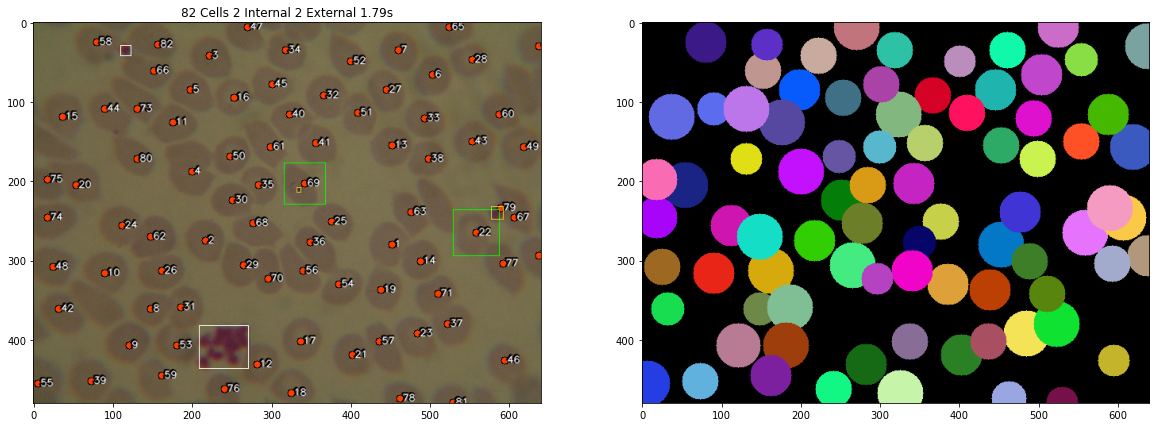

In [76]:
# https://www.programcreek.com/python/example/110725/cv2.pyrMeanShiftFiltering

def hough_circles(gray):
    
    dp=2.4
    minDist=20
    param1=1
    param2=31
    minRadius=18
    maxRadius=30

    
    labeled_img_rgb = np.zeros((gray.shape[0],gray.shape[1],3), dtype='uint8')
    numLabels, labels, stats, centroids = [], [], [], []
    
    
    #dst = cv2.pyrMeanShiftFiltering(imgBGR, 3, 5)
    #cimage = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    cimage = gray
    circles = cv2.HoughCircles(cimage, cv2.HOUGH_GRADIENT, 
                                dp=dp,
                                minDist=minDist, 
                                param1=param1, 
                                param2=param2, 
                                minRadius=minRadius, 
                                maxRadius=maxRadius)
    
    
    cellCount = 0
    
    if circles is not None:
        numLabels = len(circles[0])
        circles = np.uint16(np.around(circles))
        num = 0
        for i in circles[0, :]:
            num += 1
            x = int(i[0])
            y = int(i[1])
            R = int(i[2])
            
            #fill components props
            color = random_color()

            #define stats
            left = x - R
            left = left if x > R else 0
            top = y - R
            top = top if y > R else 0
            height = width = R*2
            area = pi*R**2
            stat = np.array([left,
                            top,
                            width,
                            height,
                            area], dtype='uint16') #area
            
            label = np.zeros((R*2,R*2),dtype='uint8')
            stats.append(stat)
            centroids.append((x,y))
            cv2.circle(label, (label.shape[0]//2, label.shape[1]//2), R, color, -1)
            labels.append(label)
            cv2.circle(labeled_img_rgb, (x, y), R, color, -1)
        
              
        return labeled_img_rgb, numLabels, labels, np.asarray(stats), centroids
    else:
        return labeled_img_rgb, numLabels, labels, np.asarray(stats), centroids

    
    
def hough_circles_method(path,mode="filterHSV"):
    start = time.time()
    img = getImage(path=path,mode=1)
    
    imgGS = getImage(path=path)
    
#     img_blur = cv2.GaussianBlur(imgGS, (5,5), 0)
#     mask = cv2.Canny(image=img_blur, threshold1=15, threshold2=10)
    
#     plt.imshow(edges,cmap='gray')
#     plt.show()
    
    mask = cv2.adaptiveThreshold(imgGS,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,301,0)
    #mask -= mask_residual
    
    mask = cv2.medianBlur(mask, 5)
    
    #plt.imshow(mask)
    #plt.show()

    par_mask = gsParasiteMask(img)
    #remove parasites from otsu
    mask = remove_parasites(mask,par_mask)

    components = hough_circles(mask)
    
    #plt.imshow(components[0])
    #plt.show()
    img, cells = markCells(img,mask=None,components=components)
        
        
        
    img, internal, external = markParasites(img,par_mask,None,components)
    end = time.time()
    passTime = "%.2fs" % (end-start)
    #save results
    saveResults(path,"HoughCircles",cells,internal,external,passTime, img, path, "_hough")
    return (img, components[0]), (cells,internal,external,passTime)

if __name__ == '__main__':

    images, stats = hough_circles_method(PATH)
    img, mask = images
    cells,internal,external,passTime = stats

    fig, ax = plt.subplots(ncols=2, figsize=(20,20))
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[0].imshow(img)
    ax[1].imshow(mask)
    plt.show()
       

In [ ]:
if __name__ == '__main__':
    img = getImage(path=PATH,mode=1)
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)

    point = (430,310)
    size = 50

    print(hsv[point])

    img[point] = 0
    img = img[point[0]-size:point[0]+size,  point[1]-size:point[1]+size]

    plt.imshow(img)
    plt.show()

    img = getImage(path=PATH,mode=1)

    #range 3
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    fromColor=(170,90,0)
    toColor=(180,100,20)
    mask1 = cv2.inRange(hsv, fromColor, toColor)
    #
    fromColor=(0,80,100)
    toColor=(13,100,120)
    mask2 = cv2.inRange(hsv, fromColor, toColor)

    fromColor=(0,80,0)
    toColor=(5,95,20)
    mask3 = cv2.inRange(hsv, fromColor, toColor)

    mask_residual = np.zeros(img.shape)
    mask_residual = cv2.bitwise_or(mask1,mask2,mask3)



        #fromColor=(0,70,105)
        #toColor=(15,100,130)

    plt.imshow(mask_residual)
    plt.show()



In [ ]:
if __name__ == '__main__':
    from ipywidgets import interact, interact_manual
    
    img = getImage(path=PATH,mode=1)

    @interact(p1=(0,180,1), p2=(0, 255, 1), p3=(0,255,1),
              v1=(0,180,1), v2=(0, 255, 1), v3=(0,255,1))
    def show_articles_more_than(p1=0, p2=86, p3=0,v1=15, v2=110, v3=255):
        hsl = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)

        mask = cv2.inRange(hsl, (p1,p2,p3), (v1,v2,v3))
        mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)

        img2 = img.copy()
        img2 *= mask
        #img = cv2.GaussianBlur(img, (35,35), 0)
        #img = cv2.equalizeHist(img)
        plt.figure(figsize=(10,10))
        plt.imshow(img2,cmap='gray')
        plt.show()



In [ ]:
if __name__ == '__main__':
    img = getImage(path=PATH,mode=1)

    @interact(p1=(0,255,1), p2=(0, 255, 1), p3=(0,255,1),
              v1=(0,255,1), v2=(0, 255, 1), v3=(0,255,1))
    def show_articles_more_than(p1=104, p2=0, p3=64,v1=120, v2=90, v3=79):

        mask = cv2.inRange(img, (p1,p2,p3), (v1,v2,v3))
        mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)

        img2 = img.copy()
        img2 *= mask
        #img2 = cv2.GaussianBlur(img2, (35,35), 0)
        img2 = cv2.medianBlur(img2, 3)
        #img = cv2.equalizeHist(img)
        plt.figure(figsize=(10,10))
        plt.imshow(img2,cmap='gray')
        plt.show()



In [ ]:
if __name__ == '__main__':
    plt.figure(figsize=(10,10))
    plt.imshow(img,cmap='gray')
    plt.show()

In [ ]:
if __name__ == '__main__':
    from ipywidgets import interact, interact_manual

    imgGS = getImage(path=PATH)
    mask = cv2.adaptiveThreshold(imgGS,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,301,0)
    it = 0


    @interact(dp=(0.01,20,.01), minDist=(1, 100, 1), param1=(0.01,1.0,0.01),#(1,301,25),
              param2=(0.01,1.0,0.01),minRadius=(0,1000,5),maxRadius=(0,1000,5))#param2=(1,100,1)
    def show_articles_more_than(dp=0.01, 
                                param1=1,
                                minDist=2,
                                param2=0.01,
                                minRadius=20,
                                maxRadius=35):
        global it
        it += 1
        print(it)
        circles = cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT_ALT, 
                                    dp=dp,
                                    minDist=minDist, 
                                    param1=param1, 
                                    param2=param2, 
                                    minRadius=minRadius, 
                                    maxRadius=maxRadius)

        vi = imgGS.copy()

        if circles is not None:
            circles = np.uint16(np.around(circles))
            num = 0
            for i in circles[0, :]:
                num += 1
                x = int(i[0])
                y = int(i[1])
                R = int(i[2])
                cv2.circle(vi, (x, y), R, 128, 1)

        fig, ax = plt.subplots(ncols=2, figsize=(20,20))
        ax[0].imshow(mask, cmap='gray')
        ax[1].imshow(vi, cmap='gray')
        plt.show()

In [ ]:
if __name__ == '__main__':


    from skimage import io, morphology, img_as_bool, segmentation
    from scipy import ndimage as ndi

    #https://learnopencv.com/edge-detection-using-opencv/
    img = getImage(path=PATH)

    #img = img[0:200,0:200]


    # Blur the image for better edge detection
    img_blur = cv2.GaussianBlur(img, (5,5), 0)


    # Sobel Edge Detection
    sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
    sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
    sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X

    # Canny Edge Detection
    edges = cv2.Canny(image=img_blur, threshold1=15, threshold2=10)

    #edges = dilate(edges,)


    #edges = colorize(edges)


    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    out = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    #out = fillHoles(out)



    #fig, ax = plt.subplots(ncols=3, figsize=(20,20))
#     ax[0].imshow(sobelx)
#     ax[1].imshow(sobely)
#     ax[2].imshow(sobelxy)
#     plt.show()
    
#     cimage = edges
#     circles = cv2.HoughCircles(cimage, cv2.HOUGH_GRADIENT, 
#                                 dp=1.8,
#                                 minDist=10, 
#                                 param1=1, 
#                                 param2=31, 
#                                 minRadius=20, 
#                                 maxRadius=30)
    
#     if circles is not None:
#         circles = np.uint16(np.around(circles))
#         num = 0
#         for i in circles[0, :]:
#             num += 1
#             x = int(i[0])
#             y = int(i[1])
#             R = int(i[2])
#             cv2.circle(out, (x, y), R, 128, -1)
    
    #out = cv2.GaussianBlur(edges, (5,5), 1)
    #out = cv2.medianBlur(edges, 3)
    edges = dilate(edges,5)
    #out = cv2.medianBlur(edges, 13)
    #out = fillHoles(edges)
    
    fig, ax = plt.subplots(ncols=2, figsize=(20,20))
    ax[0].imshow(out, cmap='gray')
    ax[1].imshow(edges, cmap='gray')
    plt.show()
    
plt.imshow(getImage(path=PATH,mode=1))
plt.show()

In [ ]:
if __name__ == '__main__':


    img = getImage(path=PATH)

    def kmeans_seg(img):
        twoDimage = img.reshape((-1,1))
        twoDimage = np.float32(twoDimage)

        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        K =2
        attempts=10

        ret,label,center = cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
        center = np.uint8(center)
        res = center[label.flatten()]
        mask = res.reshape((img.shape))


        plt.imshow(mask,cmap='gray')
        plt.show()

        MIN = np.min(mask)
        print(MIN)
        mask[mask == MIN] = 0
        mask[mask > MIN] = 255


        return mask

    mask = kmeans_seg(img)

    #labels = colorize(mask)
    labels, numLabels, labels, stats, centroids = connectedComponents(mask)

    plt.imshow(mask,cmap='gray')
    plt.show()
    plt.imshow(labels)
    plt.show()


In [ ]:
if __name__ == '__main__':
    #img = getImage(path=PATH,mode=0)

    ksize=25
    theta = np.pi/2
    kernel = cv2.getGaborKernel((ksize,ksize), 5.0, theta, 10.0, 2, 0, ktype=cv2.CV_32F)

    filtered = cv2.filter2D(img,cv2.CV_8UC3, kernel)
    plt.imshow(filtered)
    plt.show()

    from skimage.filters import threshold_otsu
    from skimage.filters.rank import entropy
    from skimage.morphology import disk

    entr = entropy(img, disk(5))
    plt.imshow(entr)
    plt.show()

    plt.hist(entr.flat, bins=100, range=(0,5))
    plt.show()

    thresh = threshold_otsu(entr)
    binary = entr <= thresh
    plt.imshow(binary)
    plt.show()

    plt.imshow(img,cmap='gray')
    plt.show()

In [ ]:
if __name__ == '__main__':
    from skimage.filters import threshold_otsu, threshold_sauvola, threshold_multiotsu, threshold_niblack
    from skimage.color import label2rgb

    img = getImage(path=PATH,mode=0)
    #thresh = threshold_otsu(img,101)
    #thresh = threshold_sauvola(img, window_size=55, k=0.05)
    #img = img <= thresh


    # thresholds = threshold_multiotsu(img)
    # regions = np.digitize(img, bins=thresholds)
    # img = label2rgb(regions)

    img2 = threshold_niblack(img,window_size=35, k=0.9)

    plt.imshow(img2)
    plt.show()

In [ ]:
if __name__ == '__main__':
    from skimage import color
    from skimage.filters import meijering, sato, frangi, hessian
    import matplotlib.pyplot as plt


    def identity(image, **kwargs):
        """Return the original image, ignoring any kwargs."""
        return image


    image = color.rgb2gray(getImage(path=PATH,mode=1))
    cmap = plt.cm.gray

    kwargs = {'sigmas': [2.0], 'mode': 'reflect'}

    fig, axes = plt.subplots(2, 5, figsize=(30,15))
    for i, black_ridges in enumerate([1, 0]):
        for j, func in enumerate([identity, meijering, sato, frangi, hessian]):
            kwargs['black_ridges'] = black_ridges
            result = func(image, **kwargs)
            axes[i, j].imshow(result, cmap=cmap, aspect='auto')
            if i == 0:
                axes[i, j].set_title(['Original\nimage', 'Meijering\nneuriteness',
                                      'Sato\ntubeness', 'Frangi\nvesselness',
                                      'Hessian\nvesselness'][j])
            if j == 0:
                axes[i, j].set_ylabel('black_ridges = ' + str(bool(black_ridges)))
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

    plt.tight_layout()
    plt.show()

In [ ]:
if __name__ == '__main__':
    from skimage import data
    from skimage import color
    from skimage.filters import meijering, sato, frangi, hessian
    import matplotlib.pyplot as plt

    img = getImage()


    img = hessian(img, sigmas=1.5, black_ridges=0, mode='reflect')

    #img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    #print(np.min(img), np.max(img))
    #img = np.uint32(img);
    #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)

    #img = cv2.GaussianBlur(img, (5,5),0)
    #img = cv2.medianBlur(img,5)

    plt.imshow(img)

In [ ]:
if __name__ == '__main__':
    from skimage import data
    from skimage import color
    from skimage.filters import meijering, sato, frangi, hessian
    import matplotlib.pyplot as plt

    img = getImage()


    img = sato(img, sigmas=1.0, black_ridges=0, mode='constant')

    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    print(np.min(img), np.max(img))
    #img = np.uint32(img);
    #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)

    #img = cv2.GaussianBlur(img, (5,5),0)
    img = cv2.medianBlur(img,5)

    plt.imshow(img)

In [ ]:
if __name__ == '__main__':
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

In [ ]:
if __name__ == '__main__':
    cimage = img.copy()
    circles = cv2.HoughCircles(cimage, cv2.HOUGH_GRADIENT, 
                                dp=2.4,
                                minDist=20, 
                                param1=1, 
                                param2=71, 
                                minRadius=20, 
                                maxRadius=30)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            x = int(i[0])
            y = int(i[1])
            R = int(i[2])
            cv2.circle(cimage, (x, y), R, 20, 2)

    plt.imshow(cimage)

In [ ]:
if __name__ == '__main__':
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import ndimage as ndi

    from skimage import (
        color, feature, filters, measure, morphology, segmentation, util
    )
    from skimage.data import human_mitosis

    image = getImage()

    #fig, ax = plt.subplots()
    #ax.imshow(image, cmap='gray')
    #ax.set_title('Microscopy image of human cells stained for nuclear DNA')
    #plt.show()

    fig, ax = plt.subplots(figsize=(10, 10))
    #qcs = ax.contour(image, origin='image', levels=[80, 90, 100], colors=['red', 'green', 'purple'], extend='both')
    qcs = ax.contour(image)
    ax.set_title('Contour plot of the same raw image')
    plt.show()

    print(qcs.levels)

In [ ]:
if __name__ == '__main__':
    thresholds = filters.threshold_multiotsu(image, classes=3)
    regions = np.digitize(image, bins=thresholds)
    plt.imshow(regions)

In [ ]:
if __name__ == '__main__':
    img = getImage(mode=1)


    def clearInfection(img, cell_mask):
        s = 200
        pos = (300,300)

        #img = img[pos[0]-s:pos[0]+s, pos[1]-s:pos[1]+s]
        #cell_mask = cell_mask[pos[0]-s:pos[0]+s, pos[1]-s:pos[1]+s]
        res = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)


        point = (100,279)
        print(res[point])
        res[point] = 0

        cv2.circle(res,point,5,5,0,-1)


        #yellow
        #[235 195  71] [241 193  57] [236 213 120]
        #cell
        #[196 113  23] [198 121  19] [205 150 100]

        #inf


        #A
        #[206  21  23] [214  31  18][220  51  10]
        #[193  92  26] [197  89  33] 
        #B
        #[212 132  93] [229 154 111][220 162 102][216 174 106]
        #C
        #[188 145 105][188 140  98]
        #D
        #[215 125  80][210 135  75][219 147  90]
        #[228 163  85]
        #[178 126  52][210 133  52]

        res2 = res.copy()
        res2 = cv2.medianBlur(res2,3)


        for x in range((res2.shape[0])):
            for y in range((res2.shape[1])):
                #A
                if (res2[x,y][1] < 100 and res2[x,y][2] > 30 or 
                    res2[x,y][1] < 140 and res2[x,y][2] > 90 or 
                    #B
                    res2[x,y][0] > 200 and res2[x,y][0] < 255 and 
                    res2[x,y][1] > 145 and res2[x,y][1] < 200 and 
                    res2[x,y][2] > 100 and res2[x,y][2] < 115 or

                    #C
                    res2[x,y][0] >= 185 and res2[x,y][0] <= 190 and 
                    res2[x,y][1] >= 140 and res2[x,y][1] <= 145 and 
                    res2[x,y][2] >= 95 and res2[x,y][2] <= 105 or

                    #D
                    res2[x,y][0] > 205 and res2[x,y][0] < 230 and 
                    res2[x,y][1] > 120 and res2[x,y][1] < 163 and 
                    res2[x,y][2] > 70 and res2[x,y][2] <= 90 or

                    res2[x,y][0] > 200 and res2[x,y][1] <= 81 and res2[x,y][2] <= 25 or

                    res2[x,y][0] > 170 and res2[x,y][0] < 210 and 
                    res2[x,y][1] > 110 and res2[x,y][1] < 130 and 
                    res2[x,y][2] > 40 and res2[x,y][2] <= 60):

                    res2[x,y][0] = 255
                    res2[x,y][1] = 0
                    res2[x,y][2] = 200
                    cell_mask[x,y] = 0



        fig, ax = plt.subplots(ncols=2,figsize=(20,20))
        #ax[0].imshow(img)
        ax[0].imshow(res)
        ax[1].imshow(res2)
        plt.show()

        return cell_mask

    cell_mask = cv2.adaptiveThreshold(imgGS,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,301,0)
    cell_mask = cv2.normalize(cell_mask, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_8U)

    infection_mask = clearInfection(getImage(mode=1),cell_mask)
    plt.imshow(infection_mask)
    plt.show()


In [ ]:
if __name__ == '__main__':
    def removeInfection(img,cell_mask):
        res = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

        hsl = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        #retira as cores avermelhadas
        mask1 = cv2.inRange(hsl, (0,85,0), (18,105,255))
        mask2 = cv2.inRange(hsl, (160,0,0), (180,255,255))

        mask_residual = cv2.bitwise_or(mask1,mask2)
        fig, ax = plt.subplots(ncols=2,figsize=(20,20))
        res = cell_mask - mask_residual
        ax[0].imshow(mask_residual)
        ax[1].imshow(res)

        return res


    imgGS = getImage()
    cell_mask = cv2.adaptiveThreshold(imgGS,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,301,0)
    cell_mask = removeInfection(getImage(mode=1),cell_mask)

In [ ]:
if __name__ == '__main__':
    img = getImage(mode=1)
    img = cv2.medianBlur(img,5)

In [ ]:
if __name__ == '__main__':
    from ipywidgets import interact, interact_manual


    @interact(p1=(0,180,1), p2=(0, 255, 1), p3=(0,255,1),
              v1=(0,180,1), v2=(0, 255, 1), v3=(0,255,1))
    def show_articles_more_than(p1=0, p2=85, p3=0,v1=19, v2=100, v3=255):



        hsl = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)

        mask1 = cv2.inRange(hsl, (p1,p2,p3), (v1,v2,v3))
        mask2 = cv2.inRange(hsl, (160,85,0), (180,105,255))

        mask_residual = cv2.bitwise_or(mask1,mask2)

        mask_residual = cv2.cvtColor(mask_residual,cv2.COLOR_GRAY2BGR)

        #mask_residual = np.zeros(img.shape)


        img2 = img.copy()
        img2 *= mask_residual
        #img = cv2.GaussianBlur(img, (35,35), 0)
        #img = cv2.equalizeHist(img)
        plt.figure(figsize=(10,10))
        plt.imshow(img2,cmap='gray')
        plt.show()



In [ ]:
if __name__ == '__main__':
    def color_distance(rgb1, rgb2):
        rm = 0.5 * (rgb1[0] + rgb2[0])
        rd = ((2 + rm) * (rgb1[0] - rgb2[0])) ** 2
        gd = (4 * (rgb1[1] - rgb2[1])) ** 2
        bd = ((3 - rm) * (rgb1[2] - rgb2[2])) ** 2
        return (rd + gd + bd) ** 0.5
    img = getImage(mode=1)
    img = cv2.medianBlur(img,5)



    img1 = img[130:140,160:170]
    img2 = img[410:420,250:260]
    img3 = img[320:350,320:350]

    #good cell
    cell = (18,  99,100)#(100,85,60)#hsv/rgb
    #red external
    red = (171, 149, 91)#(91, 38, 54)#hsv/rgb
    #red lighter
    lightred = (13,  90, 111)# ( 111,  87,  69)  #hsv/rgb
    #target
    targ = (17,94,109) #(109,  92,  69) #hsv/rgb


    print("cell,red",color_distance(cell,red))
    print("cell,lightred",color_distance(cell,lightred))
    print("cell,targ",color_distance(cell,targ))

    print("lightred,red",color_distance(lightred,red))
    print("lightred,targ",color_distance(lightred,targ))

    print("red,targ",color_distance(red,targ))



In [ ]:
if __name__ == '__main__':
    img = getImage(mode=1)
    img = cv2.medianBlur(img,5)

    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)

    point = (250,440) #target
    cell = img[point]
    point = (160,135)  #good
    red = img[point]
    point = (225,170)  #red
    lightred = img[point]
    point = (375,210)  #red lighter
    targ = img[point]

    print(hsv[point])

    img[point[0]-1,point[1]] = 0
    img[point[0]+1,point[1]] = 0
    img[point[0],point[1]-1] = 0
    img[point[0],point[1]+1] = 0
    img[point] = 0

    plt.imshow(img)


In [ ]:
if __name__ == '__main__':
    #HSV

    def color_distance(rgb1, rgb2):
        rm = 0.5 * (rgb1[0] + rgb2[0])
        rd = ((2 + rm) * (rgb1[0] - rgb2[0])) ** 2
        gd = (4 * (rgb1[1] - rgb2[1])) ** 2
        bd = ((3 - rm) * (rgb1[2] - rgb2[2])) ** 2
        return (rd + gd + bd) ** 0.5
    img = getImage(mode=1)
    img = cv2.medianBlur(img,5)



    img1 = img[130:140,160:170]
    img2 = img[410:420,250:260]
    img3 = img[320:350,320:350]

    #good cell
    c1 = (100,85,60)
    #red external
    c2 = (91, 38, 54)
    #red lighter
    c3 = (111,  87,  69)
    #target
    c4 = (17,  94, 109)#(109,  92,  69)


    print("c1,c2",color_distance(c1,c2))
    print("c1,c3",color_distance(c1,c3))
    print("c1,c4",color_distance(c1,c4))

    print("c3,c2",color_distance(c3,c2))
    print("c3,c4",color_distance(c3,c4))

    print("c2,c4",color_distance(c2,c4))



In [ ]:
if __name__ == '__main__':
    img = getImage(mode=1)

    def cutCircle(img,pos,radius):
        mask = np.zeros((img.shape[0],img.shape[1]))
        cv2.circle(mask, pos, radius, 1, -1)
        new = np.zeros(img.shape, dtype='uint8')
        for x in range(img.shape[0]):
            for y in range(img.shape[1]):
                if mask[x,y]:
                    new[x,y] = img[x,y]
        return new




    new = cutCircle(img,(50,100),30)
    img = cv2.medianBlur(img,5)


    avg, median = color_average(new)
    print(avg, median)

    print(color_distance(avg, (100,85,62)))

    plt.imshow(new)
    plt.show()
    plt.imshow(mask)
    plt.show()

In [ ]:
#https://www.ti-enxame.com/pt/python/como-encontrar-cor-media-de-uma-imagem-em-python-com-opencv/831361145/

In [ ]:
if __name__ == '__main__':
    img1 = getImage(path='./samples/normal/blood_smear_3.JPG', mode=1)
    img2 = getImage(path='./samples/normal/blood_smear_5.JPG', mode=1)
    img3 = getImage(path='./samples/blood_smear_30.JPG', mode=1)
    
    s = 10
    point = (70,70)
    
    img = img1[point[0]-s:point[0]+s, point[1]-s:point[1]+s]
    #plt.imshow(img)
    #plt.show()
    
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    print(color_average(hsv))
    
    s = 10
    img = img2[point[0]-s:point[0]+s, point[1]-s:point[1]+s]
    #plt.imshow(img)
    #plt.show()
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    print(color_average(hsv))
    print()
    
    
    s = 10
    point = (35,70)
    img = img3[point[0]-s:point[0]+s, point[1]-s:point[1]+s]
    plt.imshow(img)
    plt.show()
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    print(color_average(hsv))
    print()
    
#     vals1 = img1.mean(axis=2).flatten()
#     vals2 = img2.mean(axis=2).flatten()
#     vals3 = img3.mean(axis=2).flatten()
#     # plot histogram with 255 bins
#     b, bins, patches = plt.hist(vals1, 255)
#     b, bins, patches = plt.hist(vals2, 255)
#     b, bins, patches = plt.hist(vals3, 255)
#     plt.show()
    
#     img1 = cv2.convertScaleAbs(img1, alpha=1.8, beta=0)
    
    
#     vals1 = img1.mean(axis=2).flatten()
#     vals2 = img2.mean(axis=2).flatten()
#     vals3 = img3.mean(axis=2).flatten()
#     # plot histogram with 255 bins
#     b, bins, patches = plt.hist(vals1, 255)
#     b, bins, patches = plt.hist(vals2, 255)
#     b, bins, patches = plt.hist(vals3, 255)
#     plt.show()
    
    
#     plt.imshow(img1)
#     plt.show()
    